# DWPP Real Result Analysis

## Import

In [387]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import math
from pathlib import Path
import os
from collections import defaultdict
import analysis_lib as al

path_list = ["PathA", "PathB", "PathC"]
controller_list = ["PP", "APP", "RPP", "DWPP"]
PathA, PathB, PathC = al.make_path()
reference_path = {
    "PathA": PathA,
    "PathB": PathB,
    "PathC": PathC
}
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'stix'   # ← 重要
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'


## Calc quantitative data

In [388]:
path_dir = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment")
all_data_dict = defaultdict(lambda: defaultdict(list))

for path_name in path_list:
    for controller_name in controller_list:
        data_path = path_dir / path_name / controller_name
        # each data
        for file_path in data_path.glob("*.csv"):
            # read csv
            df = pd.read_csv(file_path)
            data_dir = file_path.parent
            
            # Extract relevant data
            timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
            timestamp -= timestamp[0]  # Normalize to start from zero
            curvature = df["curvature"].to_numpy()
            v_now = df["v_now"].to_numpy()
            w_now = df["w_now"].to_numpy()
            v_cmd = df["v_cmd"].to_numpy()
            w_cmd = df["w_cmd"].to_numpy()
            actual_v = df["v_nav"].to_numpy()
            actual_w = df["w_nav"].to_numpy()
            v_real = df["v_real"].to_numpy()
            w_real = df["w_real"].to_numpy()
            dw_max_v = df["dw_v_max"].to_numpy()
            dw_max_w = df["dw_w_max"].to_numpy()
            dw_min_v = df["dw_v_min"].to_numpy()
            dw_min_w = df["dw_w_min"].to_numpy()
            v_reg = df["v_reg"].to_numpy()
            
            map_base_x = df["map_base_x"].to_numpy()
            map_base_y = df["map_base_y"].to_numpy()
            map_base_yaw = df["map_base_yaw"].to_numpy()
            velocity_violation = df["velocity_violation"].to_numpy()
            
            x, y, yaw = al.transform_pose_to_path_origin(map_base_x, map_base_y, map_base_yaw, map_base_x[0], map_base_y[0], map_base_yaw[0])
            
            # calc velocity violation ratio
            violation_rate = al.calc_violation_rate(velocity_violation)
            
            # calc tracking error
            path = al.reference_path[path_name]
            robot_path = np.vstack((x, y)).T
            tracking_errors = al.calc_tracking_error(robot_path, path)
            
            # calc travel time
            travel_time = al.measure_travel_time(timestamp)
            
            # prepare data storage
            data_dict = {"x": x, "y": y,
                         "violation_rate": violation_rate,
                         "tracking_errors": tracking_errors,
                         "travel_time": travel_time}
            
            all_data_dict[path_name][controller_name].append(data_dict)
            

- velocity violation
  - mean and std of five times
- tracking error
  - mean and std of all tracking errors, max of five times
- travel time
  - mean and std

In [389]:
def calc_mean_and_std(values, ddof=0):
    values = np.asarray(values)
    return values.mean(), values.std(ddof=ddof)

records = []

for path_name in path_list:
    
    for controller_name in controller_list:
        data_list = all_data_dict[path_name][controller_name]

        velocity_violations = [d["violation_rate"] for d in data_list]
        tracking_errors_per_trial = [d["tracking_errors"] for d in data_list]
        travel_times = [d["travel_time"] for d in data_list]

        velocity_violations_mean, velocity_violations_std = \
            calc_mean_and_std(velocity_violations)
        
        mean_tracking_errors = [errors.mean() for errors in tracking_errors_per_trial]
        mean_tracking_errors_mean, mean_tracking_errors_std = \
            calc_mean_and_std(mean_tracking_errors)

        max_tracking_errors = [errors.max() for errors in tracking_errors_per_trial]
        max_tracking_errors_mean, max_tracking_errors_std = \
            calc_mean_and_std(max_tracking_errors)

        travel_times_mean, travel_times_std = \
            calc_mean_and_std(travel_times)
        if controller_name == "DWPP" and path_name == "PathC":
            print("Debug DWPP PathC travel times:", travel_times)
        data_dict = {"path": path_name, "controller": controller_name, \
            "velocity_violation_mean": velocity_violations_mean,
            "velocity_violation_std": velocity_violations_std,
            "mean_tracking_errors_mean": mean_tracking_errors_mean,
            "mean_tracking_errors_std": mean_tracking_errors_std,
            "max_tracking_errors_mean": max_tracking_errors_mean,
            "max_tracking_errors_std": max_tracking_errors_std,
            "travel_time_mean": travel_times_mean,
            "travel_time_std": travel_times_std}
        records.append(data_dict)



Debug DWPP PathC travel times: [25.999682664871216, 26.16614603996277, 27.266417741775513, 26.63280463218689, 24.59981608390808]


In [390]:
df = pd.DataFrame(records)

In [391]:
velocity_violation_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="velocity_violation_mean"
)
velocity_violations_std_table = df.pivot(
    index="path",
    columns="controller",
    values="velocity_violation_std"
)
all_tracking_errors_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="mean_tracking_errors_mean"
)
all_tracking_errors_std_table = df.pivot(
    index="path",
    columns="controller",
    values="mean_tracking_errors_std"
)
max_tracking_errors_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="max_tracking_errors_mean"
)
max_tracking_errors_std_table = df.pivot(
    index="path",
    columns="controller",
    values="max_tracking_errors_std"
)
travel_time_mean_table = df.pivot(
    index="path",
    columns="controller",
    values="travel_time_mean"
)
travel_time_std_table = df.pivot(
    index="path",
    columns="controller",
    values="travel_time_std"
)

velocity_violation_mean_table = velocity_violation_mean_table.reindex(columns=controller_list)
velocity_violations_std_table = velocity_violations_std_table.reindex(columns=controller_list)
all_tracking_errors_mean_table = all_tracking_errors_mean_table.reindex(columns=controller_list)
all_tracking_errors_std_table = all_tracking_errors_std_table.reindex(columns=controller_list)
max_tracking_errors_mean_table = max_tracking_errors_mean_table.reindex(columns=controller_list)
max_tracking_errors_std_table = max_tracking_errors_std_table.reindex(columns=controller_list)
travel_time_mean_table = travel_time_mean_table.reindex(columns=controller_list)
travel_time_std_table = travel_time_std_table.reindex(columns=controller_list)

# to csv
velocity_violation_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/velocity_violation_mean_table.csv")
velocity_violations_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/velocity_violation_std_table.csv")
max_tracking_errors_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/max_tracking_errors_mean_table.csv")
max_tracking_errors_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/max_tracking_errors_std_table.csv")
all_tracking_errors_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/all_tracking_errors_mean_table.csv")
all_tracking_errors_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/all_tracking_errors_std_table.csv")
travel_time_mean_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/travel_time_mean_table.csv")
travel_time_std_table.to_csv("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/travel_time_std_table.csv")

## Plot Path and velocity Profile

### Plot Path

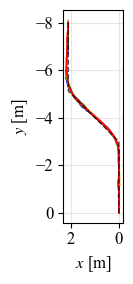

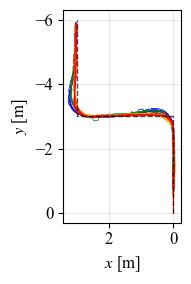

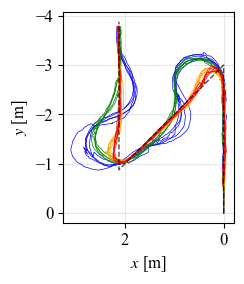

In [392]:
color_dict = {"PP": "blue", "APP": "green", "RPP": "orange", "DWPP": "red"}


for path_name in path_list:
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1, 1, 1)
    
    for controller_name in controller_list:
        data_list = all_data_dict[path_name][controller_name]
        
        xs = [d["x"] for d in data_list]
        ys = [d["y"] for d in data_list]
        
        for x, y in zip(xs, ys):
            ax.plot(y, [-x for x in x], color=color_dict[controller_name], label=controller_name, linewidth=0.5)

    ref_x = [point[0] for point in  reference_path[path_name]]
    ref_y = [point[1] for point in reference_path[path_name]]
    ax.plot(ref_y, [-x for x in ref_x], 'k--', label='Reference Path', linewidth=1, alpha=0.7)
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]')

    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()
    # plt.legend()

    filepath = f'/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/{path_name}/{path_name}_path_comparison.png'

    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

### Plot velocity profile

In [393]:
# Plot velocity profile
def plot_velocity_profile(t, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir):
    # Create subplots for translational and rotational velocities (horizontal layout)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))

    # Plot translational velocity
    ax1.plot(t, v_cmd, '-', color='red', label='Reference', linewidth=1, alpha=0.8)
    ax1.plot(t, v_real, '-', color='blue', label='Actual', linewidth=1)
    # Add velocity limit line
    ax1.axhline(y=0.50, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Max Velocity')

    # Plot rotational velocity
    ax2.plot(t, w_cmd, '-', color='red', label='Reference', linewidth=1, alpha=0.8)
    # ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
    ax2.plot(t, w_real, '-', color='blue', label='Actual', linewidth=1)
    # Add velocity limit lines
    ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Max Velocity')
    ax2.axhline(y=-1.0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Min Velocity')

    # Set labels and legends
    ax1.set_xlabel('$t$ [s]')
    ax1.set_ylabel('$v$ [m/s]')
    ax1.set_yticks([0, 0.25, 0.50])
    ax1.grid(True, alpha=0.3)
    # ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax2.set_xlabel('$t$ [s]')
    ax2.set_ylabel('$\omega$ [rad/s]')
    ax2.set_ylim(-1.5, 1.5)
    # ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax2.grid(True, alpha=0.3)
    # ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    filename = data_dir / f"{path_name}_{controller_name}_velocity.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2252490/3488213351.py:28: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_ylabel('$\omega$ [rad/s]')


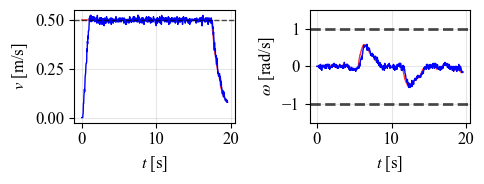

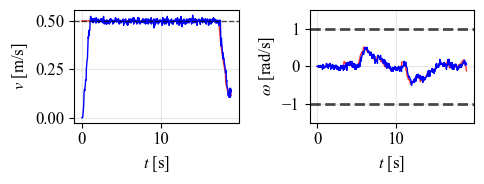

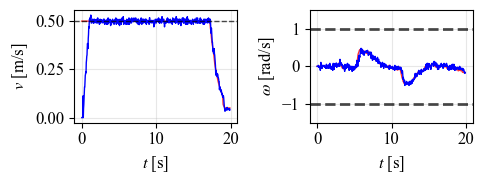

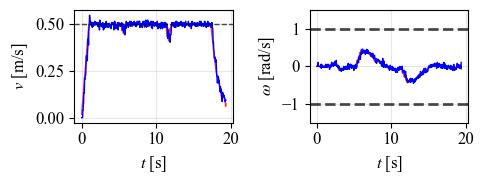

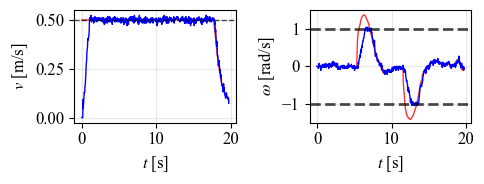

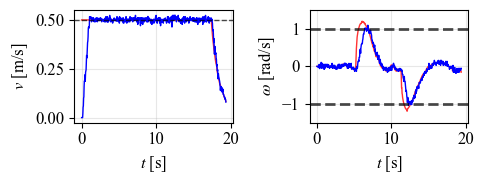

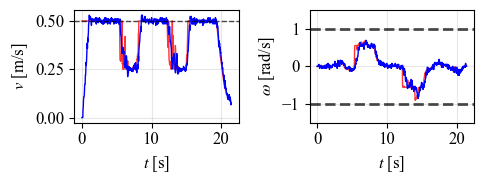

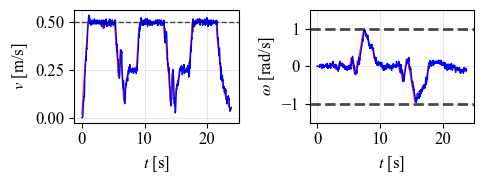

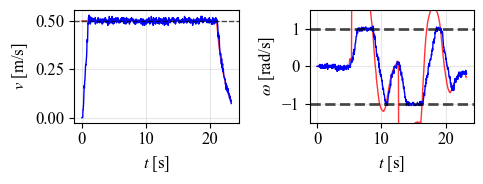

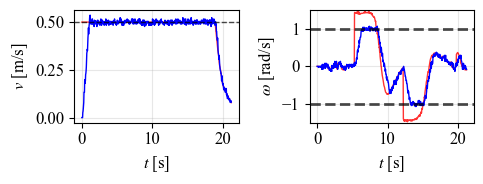

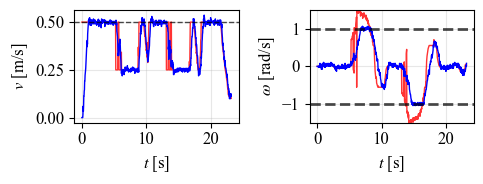

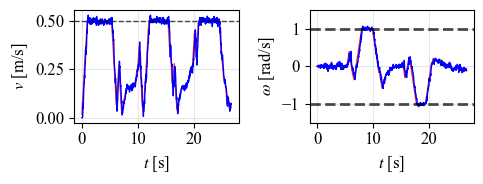

In [394]:
# set idx
idx = 3

for path_name in path_list:
    for controller_name in controller_list:
        data_path = path_dir / path_name / controller_name
        # each data
        file_paths = list(data_path.glob("*.csv"))
        file_path = file_paths[idx]
        
        # read csv
        df = pd.read_csv(file_path)
        data_dir = data_path.parent
        
        # Extract relevant data
        timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
        timestamp -= timestamp[0]  # Normalize to start from zero
        v_cmd = df["v_cmd"].to_numpy()
        w_cmd = df["w_cmd"].to_numpy()
        v_real = df["v_real"].to_numpy()
        w_real = df["w_real"].to_numpy()
        
        plot_velocity_profile(timestamp, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir)

## Compare RPP and DWPP's velocity commands

<>:69: SyntaxWarning: invalid escape sequence '\o'
<>:69: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2252490/154832031.py:69: SyntaxWarning: invalid escape sequence '\o'
  ax2.set_ylabel('$\omega$ [rad/s]')


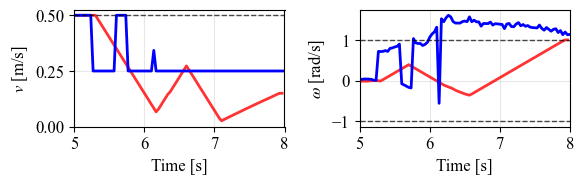

In [395]:
# set idx
idx = 3

rpp_cmd_dict = {"timestamp": [], "v_cmd": [], "w_cmd": []}
dwpp_cmd_dict = {"timestamp": [], "v_cmd": [], "w_cmd": []}

for path_name in path_list:
    for controller_name in controller_list:
        if controller_name not in ["RPP", "DWPP"]:
            continue
        data_path = path_dir / path_name / controller_name
        # each data
        file_paths = list(data_path.glob("*.csv"))
        file_path = file_paths[idx]
        
        # read csv
        df = pd.read_csv(file_path)
        data_dir = file_path.parent
        
        # Extract relevant data
        timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
        timestamp -= timestamp[0]  # Normalize to start from zero
        v_cmd = df["v_cmd"].to_numpy()
        w_cmd = df["w_cmd"].to_numpy()
        
        if controller_name == "DWPP":
            dwpp_cmd_dict["timestamp"] = timestamp
            dwpp_cmd_dict["v_cmd"] = v_cmd
            dwpp_cmd_dict["w_cmd"] = w_cmd
        elif controller_name == "RPP":
            rpp_cmd_dict["timestamp"] = timestamp
            rpp_cmd_dict["v_cmd"] = v_cmd
            rpp_cmd_dict["w_cmd"] = w_cmd


# Create subplots for translational and rotational velocities (horizontal layout)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

# Plot translational velocity
# 5s~8sに絞る
start_time = 5.0
end_time = 8.0

dwpp_mask = (dwpp_cmd_dict["timestamp"] >= start_time) & (dwpp_cmd_dict["timestamp"] <= end_time)
rpp_mask = (rpp_cmd_dict["timestamp"] >= start_time) & (rpp_cmd_dict["timestamp"] <= end_time)

ax1.plot(dwpp_cmd_dict["timestamp"][dwpp_mask], dwpp_cmd_dict["v_cmd"][dwpp_mask], '-', color='red', label='dwpp', linewidth=2, alpha=0.8)
ax1.plot(rpp_cmd_dict["timestamp"][rpp_mask], rpp_cmd_dict["v_cmd"][rpp_mask], '-', color='blue', label='rpp', linewidth=2)
# Add velocity limit line
ax1.axhline(y=0.50, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Max Velocity')

# Plot rotational velocity
ax2.plot(dwpp_cmd_dict["timestamp"][dwpp_mask], dwpp_cmd_dict["w_cmd"][dwpp_mask], '-', color='red', label='dwpp', linewidth=2, alpha=0.8)
# ax2.plot(timestamps, cmd_angular, '-', color='blue', label='Command', linewidth=3)
ax2.plot(rpp_cmd_dict["timestamp"][rpp_mask], rpp_cmd_dict["w_cmd"][rpp_mask], '-', color='blue', label='rpp', linewidth=2)
# Add velocity limit lines
ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Max Velocity')
ax2.axhline(y=-1.0, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Min Velocity')

# Set labels and legends
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('$v$ [m/s]')
ax1.set_yticks([0, 0.25, 0.50])
ax1.grid(True, alpha=0.3)
ax1.set_xlim(start_time, end_time)
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_xlabel('Time [s]')
ax2.set_ylabel('$\omega$ [rad/s]')
# ax2.set_ylim(-0.7, 0.7)
# ax2.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
ax2.grid(True, alpha=0.3)
ax2.set_xlim(start_time, end_time)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
filename = Path("/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment") / f"dwpp_rpp_comparison.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

# al.plot_velocity_profile(timestamp, v_real, w_real, v_cmd, w_cmd, path_name, controller_name, data_dir)

## Plot Dynamic Window

In [396]:
# Plot dynamic window
from pyparsing import line
from sympy import li


def plot_dynamic_window(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs, path_name, controller_name, base_dir=Path('/home/decwest/decwest_workspace/dwpp_test_simulation/data/dwpp/DynamicWindow')):
    
    save_dir = base_dir/ "DynamicWindow"
    os.makedirs(save_dir, exist_ok=True)
    
    for idx, (curvature, v, w, next_v, next_w, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg) \
        in enumerate(zip(curvatures, vs, ws, next_vs, next_ws, dw_max_vs, dw_min_vs, dw_max_ws, dw_min_ws, actual_vs, actual_ws, v_regs)):
        fig = plt.figure(figsize=(2, 2))
        ax = fig.add_subplot(1, 1, 1)
        
        acc_max = 0.5
        alpha_max = 1.0
        v_max = 0.5
        v_min = 0.0
        w_max = 1.0
        w_min = -1.0
        dw_min_v = max(v_min, v - acc_max / 30)
        dw_max_v = min(v_max, v + acc_max / 30)
        dw_min_w = max(w_min, w - alpha_max / 30)
        dw_max_w = min(w_max, w + alpha_max / 30)
        if dw_min_w > dw_max_w:
            dw_min_w = dw_max_w
        
        # vregの考慮
        regulated_bounds = [0, v_reg]
        dynamic_bounds = [dw_min_v, dw_max_v]
        # regulated_boundsとdynamic_boundsのANDをとる
        dw_min_v = max(regulated_bounds[0], dynamic_bounds[0])
        dw_max_v = min(regulated_bounds[1], dynamic_bounds[1])
        if dw_min_v > dw_max_v:
            dw_min_v = dw_max_v
        
        # Dynamic Windowの範囲を四角形でプロット
        vertexes = [
            (dw_min_v, dw_min_w),
            (dw_min_v, dw_max_w),
            (dw_max_v, dw_max_w),
            (dw_max_v, dw_min_w)
        ]
        rectangle = patches.Polygon(vertexes, closed=True, fill=False, color='black', linewidth=2, alpha=1.0, label='Dynamic Window')
        ax.add_patch(rectangle)
        
        # omega = curvature * v の直線をプロット
        v_list = np.linspace(-0.1, 0.6, 100)
        omega_line = curvature * v_list
        ax.plot(v_list, omega_line, label='ω = k * v', color="red", linewidth=2)
        
        # 現在の速度点
        ax.scatter(v, w, s=60, color='black', label='Current Velocity')
        # 速度指令値の速度点
        ax.scatter(next_v, next_w, s=60, color='green', label='Command Velocity')
        # 制御後の速度点
        ax.scatter(actual_v, actual_w, s=60, color='red', label='Actual Velocity')
        
        # v_regの描画
        ax.axvline(x=v_reg, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Regulated Velocity')
        
        # 最高速度の線の描画
        ax.axhline(y=w_max, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Max Angular Velocity')
        ax.axhline(y=-w_max, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Max Angular Velocity')
        
        ax.set_xlabel('$v$ [m/s]')
        ax.set_ylabel('$\omega$ [rad/s]')
        # for RPP
        # ax.set_xlim(0.2, 0.30)
        # ax.set_ylim(0.9, 1.5)
        
        # for DWPP
        ax.set_xlim(0.0, 0.10)
        ax.set_ylim(0.0, 0.25)
        
        ax.grid(True, alpha=0.3)
        # ax.set_aspect('equal')
        # plt.legend()
        plt.savefig(save_dir / f'{path_name}_{controller_name}_{idx}.png', dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close()

<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_2252490/2041385654.py:68: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('$\omega$ [rad/s]')


In [397]:
# set idx
from os import times

idx = 3

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

for path_name in path_list:
    if path_name != "PathC":
        continue
    for controller_name in controller_list:
        if controller_name not in ["RPP", "DWPP"]:
            continue
        data_path = path_dir / path_name / controller_name
        # each data
        file_paths = list(data_path.glob("*.csv"))
        file_path = file_paths[idx]
        
        # read csv
        df = pd.read_csv(file_path)
        data_dir = file_path.parent
        
        # Extract relevant data
        timestamp = df["sec"].to_numpy() + df["nsec"].to_numpy() * 1e-9
        timestamp -= timestamp[0]  # Normalize to start from zero
        curvature = df["curvature"].to_numpy()
        v_now = df["v_now"].to_numpy()
        w_now = df["w_now"].to_numpy()
        v_cmd = df["v_cmd"].to_numpy()
        w_cmd = df["w_cmd"].to_numpy()
        actual_v = df["v_nav"].to_numpy()
        actual_w = df["w_nav"].to_numpy()
        v_real = df["v_real"].to_numpy()
        w_real = df["w_real"].to_numpy()
        dw_max_v = df["dw_v_max"].to_numpy()
        dw_max_w = df["dw_w_max"].to_numpy()
        dw_min_v = df["dw_v_min"].to_numpy()
        dw_min_w = df["dw_w_min"].to_numpy()
        v_reg = df["v_reg"].to_numpy()
        
        start_time = 7.0
        end_time = 7.17
        
        mask = (timestamp >= start_time) & (timestamp <= end_time)
        curvature = curvature[mask]
        v_now = v_now[mask]
        w_now = w_now[mask]
        v_cmd = v_cmd[mask]
        w_cmd = w_cmd[mask]
        dw_max_v = dw_max_v[mask]
        dw_min_v = dw_min_v[mask]
        dw_max_w = dw_max_w[mask]
        dw_min_w = dw_min_w[mask]
        actual_v = actual_v[mask]
        actual_w = actual_w[mask]
        v_reg = v_reg[mask]
        print(timestamp[mask])

        plot_dynamic_window(curvature, v_now, w_now, v_cmd, w_cmd, dw_max_v, dw_min_v, dw_max_w, dw_min_w, actual_v, actual_w, v_reg, path_name, controller_name, base_dir=data_dir)

[7.03348899 7.06637979 7.10002899 7.1331358  7.16636038]
[7.03306055 7.0666244  7.10008287 7.13310266 7.16638088]


## Plot reference path

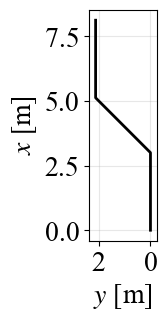

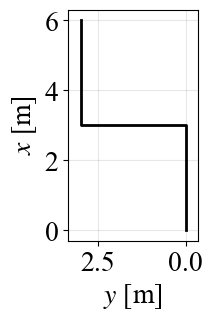

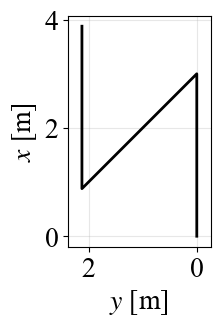

In [398]:

for path_name in path_list:

    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1, 1, 1)

    ref_x = [point[0] for point in reference_path[path_name]]
    ref_y = [point[1] for point in reference_path[path_name]]

    # y を横軸、x を縦軸にそのままプロット
    ax.plot(ref_y, ref_x, linewidth=2, color="black")

    ax.set_xlabel('$y$ [m]')
    ax.set_ylabel('$x$ [m]')

    # 座標系の向きを制御
    ax.invert_xaxis()   # 左方向が +y
    # ax.invert_yaxis()   # 上方向が +x

    ax.grid(True, alpha=0.3)
    ax.margins(x=0.12, y=0.05)  # ← 左右に余裕
    
    ax.set_aspect('equal')

    filepath = f'/home/decwest/decwest_workspace/dwpp_test_simulation/data/real_robot_experiment/reference_path_{path_name}.png'
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
